In [1]:
import os
import pathlib

base_directory = os.getcwd() # store your base directory for easy reference
assignment_two_data = base_directory + '/Homework_Two_Data/'

In [2]:
# Load core libraries and utilities
import numpy as np
import matplotlib.pyplot as plt
from math_596_image_analysis_helper_functions import *
from sklearn.cluster import KMeans

# Jupyter notebook "magic"
%matplotlib inline

In [3]:
cropped_directory = assignment_two_data + '/CroppedYale/'
cropped_image_list = file_builder(cropped_directory)

# For Windows users, you might need this instead:
# win_cropped_directory = pathlib.PureWindowsPath(cropped_directory)
# cropped_image_list = file_builder(win_cropped_directory)

In [4]:
def cluster_data_maker(images_mat, mode_choices):
    zero_avg, _ = zero_mean(images_mat)
    u_modes, s_vals = mode_builder(zero_avg)
    u_modes_red = mode_selector(u_modes, s_vals, 1.)

    projected_images = u_modes_red.T @ zero_avg
    cluster_data = []
    for mode in mode_choices:
        cluster_data.append(projected_images[mode, :])
    cluster_data = np.array(cluster_data)
    
    return cluster_data

# Generate initial labels for "ground truth" data set
def mode_and_kmeans_label_maker(images_mat, num_clusters, mode_choices):
    
    cluster_data = cluster_data_maker(images_mat, mode_choices)
    kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init="auto").fit(cluster_data.T)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    return labels, centers, cluster_data  

# When we relabel, we make sure to reuse old centers so we don't get random label assignment
def mode_and_kmeans_relabel(cluster_data, num_clusters, prior_centers):

    kmeans = KMeans(n_clusters=num_clusters, init=prior_centers, n_init="auto").fit(cluster_data.T)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    return labels, centers, cluster_data  


In [5]:
def cluster_separation(cluster_data, labels, num_clusters):
    label_types = np.arange(num_clusters, dtype=int)
    groups = []
    for label_type in label_types:
        next_group = labels == label_type
        groups.append(cluster_data[:, next_group])
    return groups

def cluster_plots(cluster_data, labels, centers):

    num_dims = centers.shape[1]
    num_clusters = centers.shape[0]

    colors = ['r', 'k', 'b']
    clusters = cluster_separation(cluster_data, labels, num_clusters)
    
    fig = plt.figure()            
    if num_dims == 2:
        ax = fig.add_subplot(1, 1, 1)        
        ax.scatter(centers[:, 0], centers[:, 1], s=40., c='g', marker='x')
        for jj in range(len(clusters)): 
            ax.scatter(clusters[jj][0, :], clusters[jj][1, :], s=2., c=colors[jj])
    elif num_dims == 3:
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], s=40., c='g', marker='x')
        for jj in range(len(clusters)):
            ax.scatter(clusters[jj][0, :], clusters[jj][1, :], clusters[jj][2,:], s=2., c=colors[jj])
        
    

In [6]:
def kfold_validator(cluster_data, labels, centers):
    tot_images = cluster_data.shape[1]
    #num_cut = int(np.floor(.1 * tot_images))
    tot_indices = np.arange(tot_images)
    num_dims = centers.shape[1]
    num_clusters = centers.shape[0]
    colors = ['r', 'k', 'b']
    rng = np.random.default_rng()

    fig = plt.figure(figsize=(12, 8))
    nsamps = 400
    dif_vals = np.zeros(nsamps)        
    samp_images = int(np.floor(.9 * tot_images))
    for jj in range(nsamps):
        #print(f"Checking {jj}-th subset of images.")
        rng.shuffle(tot_indices)
        red_indices = np.sort(tot_indices[:samp_images])

        ref_labels = labels[red_indices]
        red_labels, red_centers, red_cluster_data = mode_and_kmeans_relabel(cluster_data[:, red_indices], num_clusters, centers)     
        red_clusters = cluster_separation(red_cluster_data, red_labels, num_clusters)

        absdifs = np.abs( red_labels - ref_labels )
        if num_clusters == 3:
            dblinds = absdifs >= 1.
            absdifs[dblinds] == 1
        dif_vals[jj] = np.sum(absdifs)/red_labels.size
        
        # plotting
        if jj < 10:
            if num_dims == 2:
                ax = fig.add_subplot(2, 5, jj+1)
                ax.scatter(red_centers[:, 0], red_centers[:, 1], s=40., c='g', marker='x')
                for jj in range(len(red_clusters)): 
                    ax.scatter(red_clusters[jj][0, :], red_clusters[jj][1, :], s=2., c=colors[jj])
            elif num_dims == 3:
                ax = fig.add_subplot(2, 5, jj+1, projection='3d')
                ax.scatter(red_centers[:, 0], red_centers[:, 1], red_centers[:, 2], s=40., c='g', marker='x')
                for jj in range(len(red_clusters)):
                    ax.scatter(red_clusters[jj][0, :], red_clusters[jj][1, :], red_clusters[jj][2,:], s=2., c=colors[jj])
                
        fig.tight_layout()
    return dif_vals

In [7]:
# Same stuff from lecture notes:

num_crp_images = len(cropped_image_list)
crp_row, crp_col = np.shape(cropped_image_list[0])
crp_image_mat = np.zeros((crp_row*crp_col, num_crp_images), dtype=np.float64)
for cnt, image in enumerate(cropped_image_list):
    crp_image_mat[:, cnt] = image.flatten()

print(f"Total number of images is: {num_crp_images}")
print(f"Pixel counts are {crp_row} by {crp_col}")

Total number of images is: 512
Pixel counts are 192 by 168


**Problem 1**: Using the cropped image list from Homework 2, following our study of using k-means clusters on the scatter plot of `projected_images[0, :]` and `projected_images[1, :]` as shown in `Applications_of_the_SVD_and_Cluster_Analysis.ipynb`, we want to study how sensisitve the labels we used are.  To do this:

* Remove 10% of the total images and then label the remaining 90% of the images.  Compare your labels that you generated for the full data set to your new ones (relative of course to the common 90% of images you are working with) and compute the average difference as a percentage of the total number of images in your 90% set.  

* Repeat this process 9 more times by removing a different 10% of the data each time.  This should generate 9 more average differences.  

* Plot your results and comment upon them.  How robust are the labels?  How effective would you say that our labeling scheme is?  

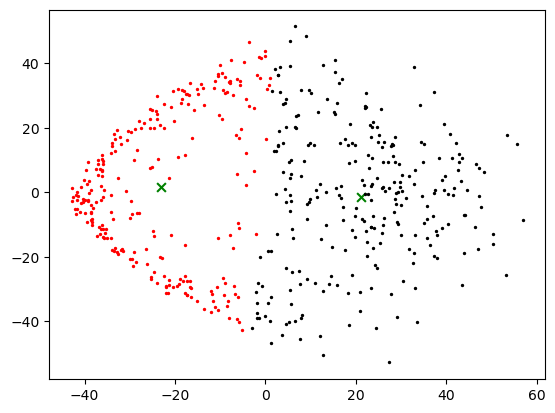

In [8]:
# To build your 90%/10% splits in the data, we shuffle our images first 
# and then build our modes and find our labels for the full data set 
# relative to a fixed shuffle of the image indices.  

rng = np.random.default_rng()
image_indices = np.arange(num_crp_images)
rng.shuffle(image_indices)
crp_image_mat = crp_image_mat[:, image_indices]
labels, centers, cluster_data = mode_and_kmeans_label_maker(crp_image_mat, 2, [0, 1])
cluster_plots(cluster_data, labels, centers)

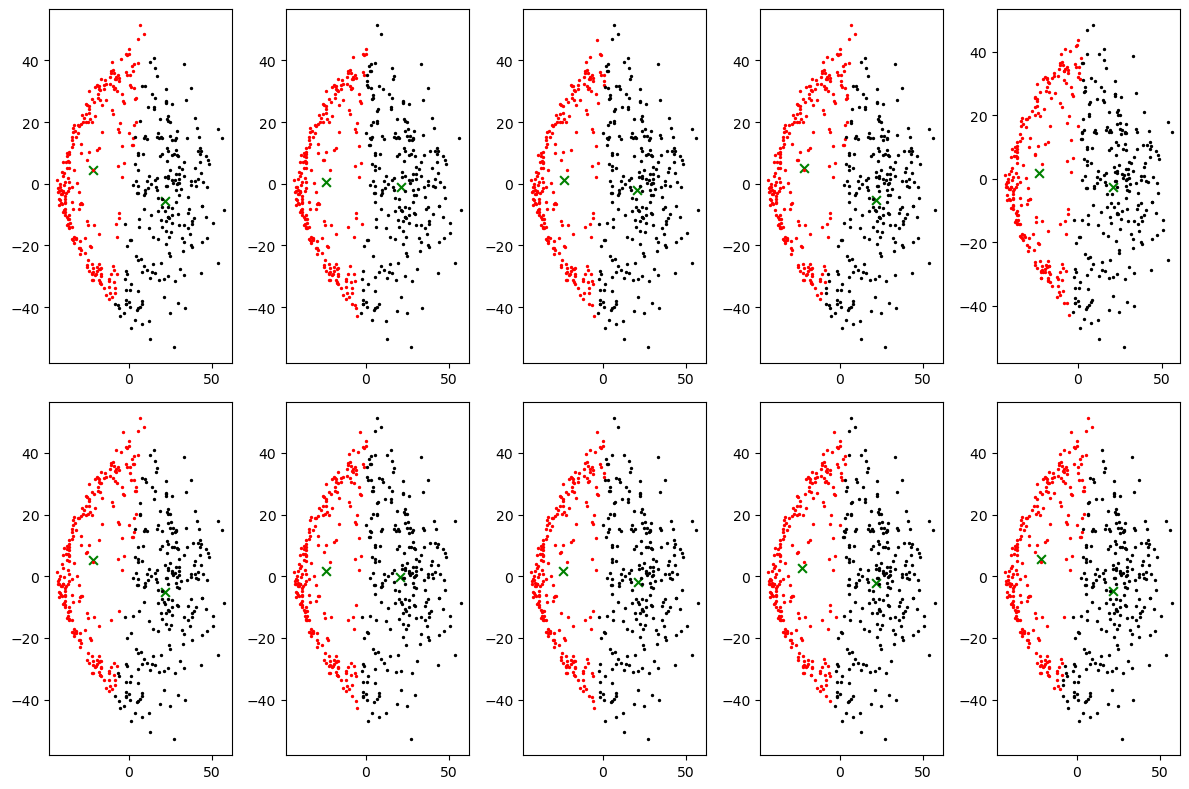

In [9]:
dif_vals = kfold_validator(cluster_data, labels, centers)

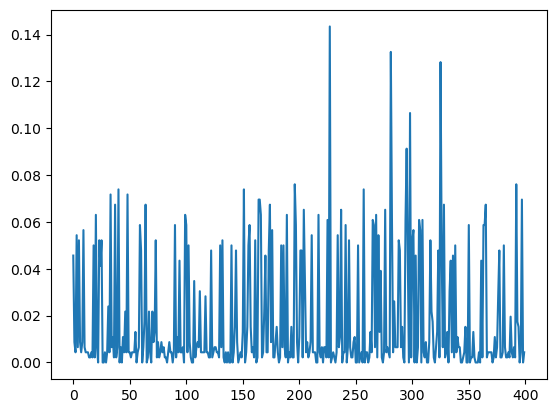

In [10]:
plt.plot(dif_vals)

**Problem 2**: Repeat the above analysis using two kmeans labels and the modes `projected_images[0, :]`, `projected_images[1, :]`, and `projected_images[3, :]`.  How do your results change?  

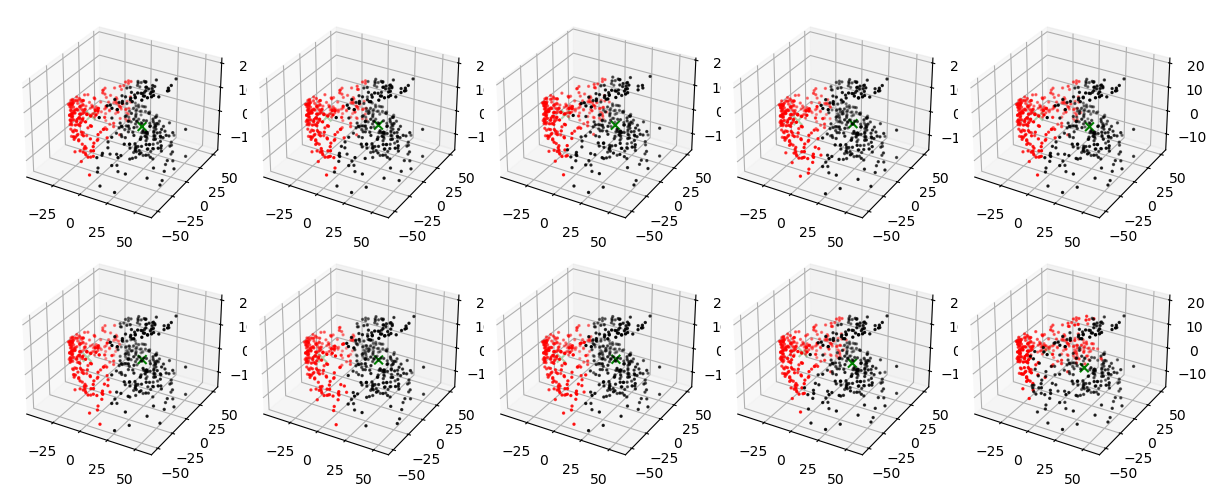

In [11]:
labels, centers, cluster_data = mode_and_kmeans_label_maker(crp_image_mat, num_clusters=2, mode_choices=[0, 1, 3])
dif_vals = kfold_validator(cluster_data, labels, centers)

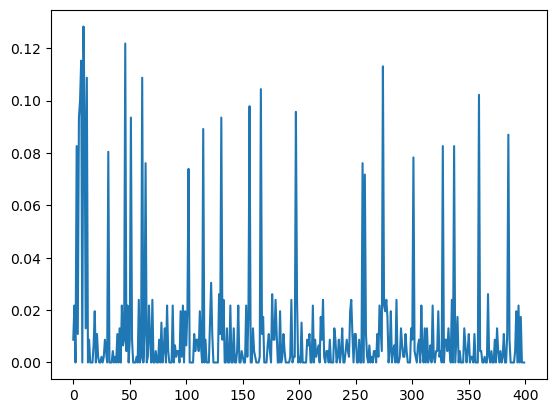

In [12]:
plt.plot(dif_vals)

**Problem 3**: Repeat the above analysis using three kmeans labels and the modes `projected_images[0, :]`, `projected_images[1, :]`, and `projected_images[3, :]`.  How do your results change?  Which would you say is the best labeling scheme?  

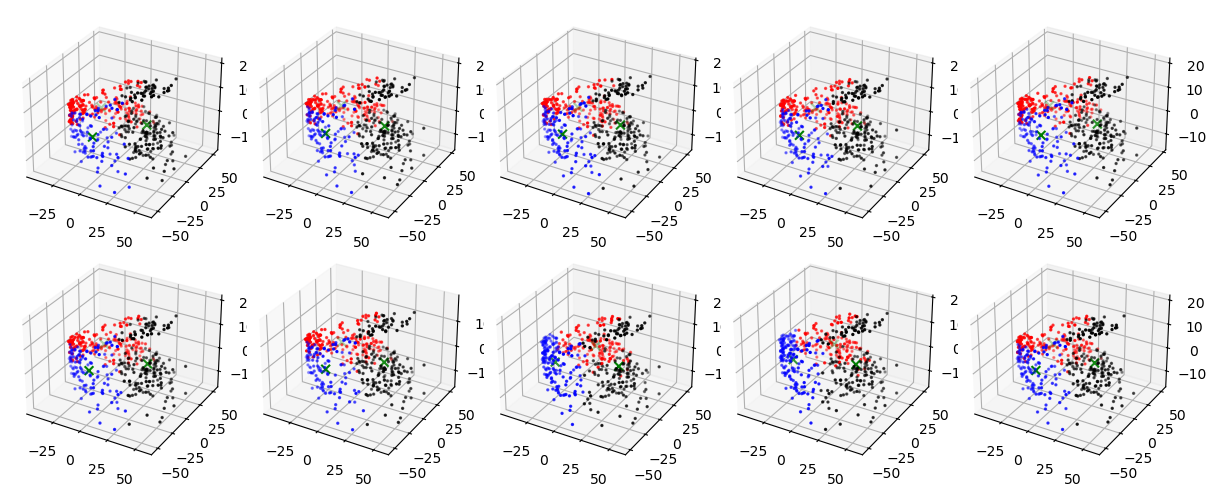

In [13]:
tdlabels, tdcenters, tdcluster_data = mode_and_kmeans_label_maker(crp_image_mat, num_clusters=3, mode_choices=[0, 1, 3])
tddif_vals = kfold_validator(tdcluster_data, tdlabels, tdcenters)

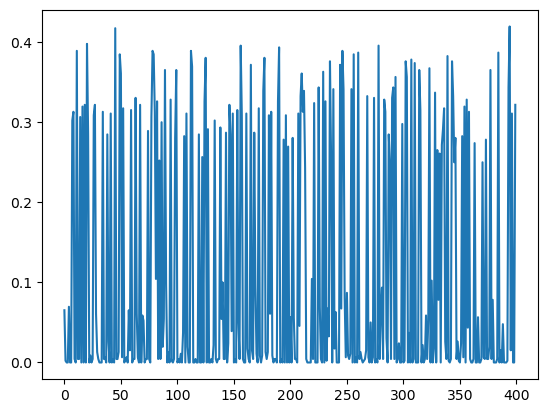

In [14]:
plt.plot(tddif_vals)